# Hate Speech (Deutsch & Schweizerdeutsch) – Transformer Modell

Kontextsensitives Modell mit **deepset/gbert-base**: Training, Evaluation, Explainability (SHAP für Text), Bias-Screening und Active Learning.

## 0. Installation und Setup

In [23]:
%pip install -q transformers datasets accelerate torch shap scikit-learn pandas matplotlib tf-keras

Note: you may need to restart the kernel to use updated packages.


In [24]:
# Fix für Keras 3 Kompatibilität mit Transformers
# Falls der Fehler "No module named 'tf_keras'" auftritt, installiere tf-keras
try:
    import tf_keras
except ImportError:
    print("Installiere tf-keras für Keras 3 Kompatibilität...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "tf-keras"])
    print("✅ tf-keras erfolgreich installiert. Bitte Kernel neu starten und Zellen erneut ausführen.")


## 1. Importe, Konfiguration und GPU-Erkennung

In [25]:
import os, random, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import date

import torch
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, EarlyStoppingCallback)

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

BASE_MODEL_NAME = "deepset/gbert-base"
TODAY = "2025-11-04"
RUN_NAME = f"{BASE_MODEL_NAME.split('/')[-1]}_gahd_hatespeech_{TODAY}"
OUT_DIR = Path("results_" + RUN_NAME)
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Run:", RUN_NAME)
print("Modell:", BASE_MODEL_NAME)
print("Ausgabeordner:", OUT_DIR)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Gerät:", device)


Run: gbert-base_gahd_hatespeech_2025-11-04
Modell: deepset/gbert-base
Ausgabeordner: results_gbert-base_gahd_hatespeech_2025-11-04
Gerät: cpu


## 2. Daten laden

In [ ]:
# Lade Trainings- und Testdaten aus den aufgeteilten CSV-Dateien
train_df = pd.read_csv("../data/de_hf_112024_train.csv", encoding="utf-8")
validate_df = pd.read_csv("../data/de_hf_112024_val.csv", encoding="utf-8")

# Stelle sicher, dass text und labels vorhanden sind
train_df["text"] = train_df["text"].fillna("")
validate_df["text"] = validate_df["text"].fillna("")

# Konvertiere labels zu Integer (falls noch nicht geschehen)
train_df["labels"] = train_df["labels"].astype(int)
validate_df["labels"] = validate_df["labels"].astype(int)

print("Trainingsdatensatz:")
print(f"  Shape: {train_df.shape}")
print(f"  Label-Verteilung:")
print(train_df["labels"].value_counts().sort_index())
print(f"\nTestdatensatz:")
print(f"  Shape: {validate_df.shape}")
print(f"  Label-Verteilung:")
print(validate_df["labels"].value_counts().sort_index())
print(f"\nErste Zeilen des Trainingsdatensatzes:")
train_df.head(3)

Trainingsdatensatz:
  Shape: (38412, 2)
  Label-Verteilung:
labels
0    33626
1     4786
Name: count, dtype: int64

Testdatensatz:
  Shape: (9603, 2)
  Label-Verteilung:
labels
0    8407
1    1196
Name: count, dtype: int64

Erste Zeilen des Trainingsdatensatzes:


,text,labels
0,Wenn es zu kalt ist : Klimawandel Wenn es zu w...,0
1,"Wie wäre es denn mit ""Flugblätter"" verteilen?",0
2,Und da kommt schon die nächste Horrormeldung: ...,0


## 3. Train/Test-Split

In [ ]:
# Die Daten sind bereits in train_df und test_df geladen
# Kein zusätzlicher Split nötig, da die Daten bereits aufgeteilt sind

print("Train:", train_df.shape, "Test:", validate_df.shape)
print(f"\nTrainingsdatensatz: {len(train_df)} Zeilen")
print(f"Testdatensatz: {len(validate_df)} Zeilen")

# Konvertiere zu HuggingFace Datasets
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
test_ds  = Dataset.from_pandas(validate_df.reset_index(drop=True))

Train: (38412, 2) Test: (9603, 2)

Trainingsdatensatz: 38412 Zeilen
Testdatensatz: 9603 Zeilen


## 4. Tokenizer & Tokenisierung

In [28]:
# ==========================================================
# Abschnitt 4: Tokenizer & Tokenisierung (Windows-kompatibel)
# ==========================================================

from transformers import AutoTokenizer

# Prüfen, ob Tokenizer vorhanden ist, sonst neu laden
try:
    tokenizer
except NameError:
    print("Tokenizer nicht definiert – lade neu ...")
    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
else:
    print("Tokenizer bereits geladen.")

# Parameter für Tokenisierung
MAX_LEN = 160

def tok(batch):
    """Tokenisiert Text für Transformer-Eingabe."""
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN
    )

print("Starte Tokenisierung (ohne Parallelverarbeitung – stabil unter Windows) ...")

# ❗ Wichtig: Kein num_proc hier – sonst verliert Windows den Tokenizer-Kontext
train_ds = train_ds.map(tok, batched=True, desc="Train-Dataset tokenisieren")
test_ds  = test_ds.map(tok, batched=True, desc="Test-Dataset tokenisieren")

# Labels sicherstellen (sollte bereits "labels" heißen, aber zur Sicherheit prüfen)
if "label" in train_ds.column_names:
    train_ds = train_ds.rename_column("label", "labels")
if "label" in test_ds.column_names:
    test_ds = test_ds.rename_column("label", "labels")
# Die Spalte sollte bereits "labels" heißen, da die CSV-Dateien diese Spalte verwenden

# Relevante Spalten setzen
cols = ["input_ids", "attention_mask", "labels"]
train_ds.set_format(type="torch", columns=cols)
test_ds.set_format(type="torch", columns=cols)

print("✅ Tokenisierung erfolgreich abgeschlossen!")
print("Beispiel-Token:", tokenizer.decode(train_ds[0]["input_ids"][:20]))


Tokenizer bereits geladen.
Starte Tokenisierung (ohne Parallelverarbeitung – stabil unter Windows) ...


Test-Dataset tokenisieren: 100%|██████████| 9603/9603 [00:00<00:00, 15135.40 examples/s]

✅ Tokenisierung erfolgreich abgeschlossen!
Beispiel-Token: [CLS] Wenn es zu kalt ist : Klimawandel Wenn es zu warm ist : Klimawandel Wenn zu nass ist


## 5. Modell laden

In [29]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL_NAME, num_labels=2)
model.to("cuda" if torch.cuda.is_available() else "cpu")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31102, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## 6. Trainingsargumente

In [30]:
# ============================================
# Abschnitt 6: Trainingsargumente (robust & kompatibel)
# ============================================
import torch
from transformers import TrainingArguments

# Anzeige: GPU oder CPU
device_name = "GPU" if torch.cuda.is_available() else "CPU"
print(f"Trainingsgerät: {device_name}")

# Standard-Hyperparameter
BATCH = 16
EPOCHS = 4
LR = 2e-5
fp16_use = torch.cuda.is_available()

# Minimaler, sicherer Satz Trainingsargumente
training_args = TrainingArguments(
    output_dir=str(OUT_DIR),                 # Ausgabeverzeichnis
    learning_rate=LR,                        # Lernrate
    per_device_train_batch_size=BATCH,       # Batchgröße pro Gerät im Training
    per_device_eval_batch_size=BATCH,        # Batchgröße für Evaluation
    num_train_epochs=EPOCHS,                 # Epochenanzahl
    weight_decay=0.01,                       # Gewichtsregularisierung
    save_strategy="epoch",                   # Speichern nach jeder Epoche
    save_total_limit=2,                      # Max. 2 Checkpoints behalten
    logging_steps=50,                        # Logausgabe alle 50 Schritte
    report_to="none",                        # Keine externe Protokollierung
    fp16=fp16_use                            # Mixed Precision, falls GPU
)

print("✅ Trainingsargumente initialisiert.")
print(training_args)


Trainingsgerät: CPU
✅ Trainingsargumente initialisiert.
TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=True,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strat

## 7. Trainer mit Metriken und Early Stopping

In [31]:
# ============================================
# Abschnitt 7: Trainer-Initialisierung
# ============================================
from transformers import Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# --- Bewertungsfunktion definieren ---
def compute_metrics(eval_pred):
    """
    Berechnet Standardmetriken für Klassifikation:
    Accuracy, Precision, Recall und F1-Score.
    """
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, zero_division=0),
        "recall": recall_score(labels, preds, zero_division=0),
        "f1": f1_score(labels, preds, zero_division=0),
    }

# --- Trainer erstellen ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    processing_class=tokenizer,  # modern ersetzt tokenizer=
    compute_metrics=compute_metrics
)

print("✅ Trainer erfolgreich initialisiert.")
print("Bereit zum Start des Trainings: trainer.train()")


✅ Trainer erfolgreich initialisiert.
Bereit zum Start des Trainings: trainer.train()


## 8. Evaluation und Speichern

In [32]:
# ============================================
# Abschnitt 8: Training, Evaluation & Speichern
# ============================================
import os

# --- Training starten ---
print("🚀 Starte Feintuning auf Hate-Speech-Daten ...")
train_result = trainer.train()

# --- Trainingsergebnisse protokollieren ---
print("\n✅ Training abgeschlossen.")
print("Trainingsergebnisse:")
print(train_result)

# --- Evaluation auf Testdaten ---
print("\n📊 Starte Evaluation auf Testdaten ...")
eval_results = trainer.evaluate()

print("\nErgebnisse der Evaluation:")
for key, value in eval_results.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

# --- Modell & Tokenizer speichern ---
MODEL_SAVE_PATH = os.path.join(str(OUT_DIR), "final_model")
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

print(f"\n💾 Speichere Modell und Tokenizer nach: {MODEL_SAVE_PATH}")
trainer.save_model(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

print("\n✅ Modell und Tokenizer erfolgreich gespeichert.")
print("Pfad:", MODEL_SAVE_PATH)


🚀 Starte Feintuning auf Hate-Speech-Daten ...


c:\Users\mirko\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,0.332700
100,0.310800
150,0.288600
200,0.274600
250,0.239400
300,0.270700
350,0.236600
400,0.306700
450,0.253400
500,0.239000


c:\Users\mirko\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\mirko\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\mirko\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



✅ Training abgeschlossen.
Trainingsergebnisse:
TrainOutput(global_step=9604, training_loss=0.14548661546166466, metrics={'train_runtime': 61128.1368, 'train_samples_per_second': 2.514, 'train_steps_per_second': 0.157, 'total_flos': 1.26332773231104e+16, 'train_loss': 0.14548661546166466, 'epoch': 4.0})

📊 Starte Evaluation auf Testdaten ...


c:\Users\mirko\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Ergebnisse der Evaluation:
eval_loss: 0.4249
eval_accuracy: 0.9227
eval_precision: 0.7121
eval_recall: 0.6371
eval_f1: 0.6726
eval_runtime: 843.3057
eval_samples_per_second: 11.3870
eval_steps_per_second: 0.7130
epoch: 4.0000

💾 Speichere Modell und Tokenizer nach: results_gbert-base_gahd_hatespeech_2025-11-04\final_model

✅ Modell und Tokenizer erfolgreich gespeichert.
Pfad: results_gbert-base_gahd_hatespeech_2025-11-04\final_model


8.1 Extrahiere model in anderes Format

In [35]:
# Installation der benötigten Pakete für ONNX-Export
print("Installiere Pakete für ONNX-Export...")
import subprocess
import sys

# Installiere Pakete einzeln mit Fehlerbehandlung
packages_to_install = [
    (["optimum==1.17.1", "onnxruntime==1.17.3"], ["--prefer-binary", "--no-cache-dir"]),
    (["onnxscript==0.5.6"], ["--extra-index-url", "https://pypi.org/simple", "--no-cache-dir"])
]

for packages, extra_args in packages_to_install:
    cmd = [sys.executable, "-m", "pip", "install"] + packages + extra_args
    print(f"Installiere: {', '.join(packages)}...")
    try:
        result = subprocess.run(cmd, capture_output=True, text=True, check=False)
        if result.returncode == 0:
            print(f"✅ {', '.join(packages)} erfolgreich installiert")
        else:
            print(f"⚠️  Warnung bei Installation von {', '.join(packages)}:")
            if result.stderr:
                print(f"   Fehler: {result.stderr[:200]}")
            # Versuche trotzdem weiter
    except Exception as e:
        print(f"⚠️  Fehler bei Installation von {', '.join(packages)}: {e}")
        print("   Versuche trotzdem weiter...")

print("\n✅ Installation abgeschlossen.")
print("⚠️  WICHTIG: Bitte Kernel neu starten (Kernel → Restart Kernel) und diese Zelle erneut ausführen!")

# Versuche Imports (können fehlschlagen, wenn Kernel nicht neu gestartet wurde)
print("\nPrüfe Imports...")
try:
    import optimum
    print("✅ optimum importiert")
except ImportError as e:
    print(f"⚠️  optimum konnte nicht importiert werden: {e}")
    print("   Versuche Installation ohne Versionsbeschränkung...")
    try:
        subprocess.run([sys.executable, "-m", "pip", "install", "optimum", "--quiet"], check=False)
    except:
        pass

try:
    import onnxruntime
    print(f"✅ onnxruntime importiert (Version: {onnxruntime.__version__})")
except ImportError as e:
    print(f"⚠️  onnxruntime konnte nicht importiert werden: {e}")

try:
    import onnxscript
    print(f"✅ onnxscript importiert (Version: {onnxscript.__version__})")
except ImportError as e:
    print(f"⚠️  onnxscript konnte nicht importiert werden: {e}")

print("\n💡 Tipp: Falls Imports fehlschlagen, starten Sie den Kernel neu (Kernel → Restart Kernel)")

Installiere Pakete für ONNX-Export...
Installiere: optimum==1.17.1, onnxruntime==1.17.3...
⚠️  Warnung bei Installation von optimum==1.17.1, onnxruntime==1.17.3:
   Fehler: ERROR: Could not find a version that satisfies the requirement onnxruntime==1.17.3 (from versions: 1.20.0, 1.20.1, 1.21.0, 1.21.1, 1.22.0, 1.22.1, 1.23.0, 1.23.1, 1.23.2)
ERROR: No matching distributi
Installiere: onnxscript==0.5.6...
✅ onnxscript==0.5.6 erfolgreich installiert

✅ Installation abgeschlossen.
⚠️  WICHTIG: Bitte Kernel neu starten (Kernel → Restart Kernel) und diese Zelle erneut ausführen!

Prüfe Imports...
⚠️  optimum konnte nicht importiert werden: No module named 'optimum'
   Versuche Installation ohne Versionsbeschränkung...
⚠️  onnxruntime konnte nicht importiert werden: No module named 'onnxruntime'
✅ onnxscript importiert (Version: 0.5.6)

💡 Tipp: Falls Imports fehlschlagen, starten Sie den Kernel neu (Kernel → Restart Kernel)


In [39]:
import onnxscript
print("onnxscript:", onnxscript.__version__)

onnxscript: 0.5.6


In [45]:
# Exportiere das trainierte Modell in ONNX-Format
print("Exportiere Modell in ONNX-Format...")

import subprocess
import sys
import os

MODEL_SAVE_PATH = os.path.join(str(OUT_DIR), "final_model")
ONNX_PATH = os.path.join(MODEL_SAVE_PATH, "model.onnx")

# Versuche zuerst optimum zu installieren, falls es fehlt
optimum_available = False
try:
    from optimum.onnxruntime import ORTModelForSequenceClassification
    optimum_available = True
except ImportError:
    print("⚠️  optimum nicht verfügbar. Versuche Installation...")
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "optimum[onnxruntime]", "--quiet"])
        from optimum.onnxruntime import ORTModelForSequenceClassification
        optimum_available = True
        print("✅ optimum erfolgreich installiert")
    except Exception as e:
        print(f"⚠️  Installation von optimum fehlgeschlagen: {e}")
        optimum_available = False

if optimum_available:
    try:
        print(f"Lade Modell von: {MODEL_SAVE_PATH}")
        
        # Methode 1: Versuche mit export=True
        try:
            ort_model = ORTModelForSequenceClassification.from_pretrained(
                MODEL_SAVE_PATH,
                export=True  # Exportiert zu ONNX
            )
            # Speichere explizit, um sicherzustellen, dass die Datei erstellt wird
            ort_model.save_pretrained(MODEL_SAVE_PATH)
        except Exception as e1:
            print(f"⚠️  Export mit export=True fehlgeschlagen: {e1}")
            # Methode 2: Lade Modell und exportiere manuell
            print("Versuche manuellen Export...")
            from optimum.onnxruntime import ORTModelForSequenceClassification
            from optimum.onnxruntime import ORTConfig
            
            # Lade das PyTorch-Modell
            from transformers import AutoModelForSequenceClassification
            pytorch_model = AutoModelForSequenceClassification.from_pretrained(MODEL_SAVE_PATH)
            
            # Exportiere zu ONNX
            ort_model = ORTModelForSequenceClassification.from_pretrained(
                MODEL_SAVE_PATH,
                export=True,
                provider="CPUExecutionProvider"
            )
            ort_model.save_pretrained(MODEL_SAVE_PATH)
        
        # Prüfe ob ONNX-Datei existiert
        if os.path.exists(ONNX_PATH):
            print(f"✅ ONNX-Datei erfolgreich erstellt: {ONNX_PATH}")
        else:
            # Suche nach ONNX-Dateien im Verzeichnis
            onnx_files = [f for f in os.listdir(MODEL_SAVE_PATH) if f.endswith('.onnx')]
            if onnx_files:
                print(f"✅ ONNX-Dateien gefunden: {onnx_files}")
            else:
                print(f"⚠️  ONNX-Datei nicht gefunden. Versuche alternative Methode...")
                optimum_available = False
        
    except Exception as e:
        print(f"⚠️  Fehler beim Export mit optimum: {e}")
        print("Versuche alternative Methode...")
        optimum_available = False

# Alternative Methode mit transformers.onnx
if not optimum_available:
    try:
        from transformers import AutoModelForSequenceClassification
        from transformers.onnx import export
        
        print(f"Lade Modell von: {MODEL_SAVE_PATH}")
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_SAVE_PATH)
        
        # Exportiere zu ONNX - korrekte Signatur: export(model, tokenizer, output, opset=12)
        print(f"Exportiere zu ONNX: {ONNX_PATH}")
        export(model, tokenizer, ONNX_PATH, opset=12)
        
        # Prüfe ob Datei erstellt wurde
        if os.path.exists(ONNX_PATH):
            file_size = os.path.getsize(ONNX_PATH) / (1024 * 1024)  # Größe in MB
            print(f"✅ Modell erfolgreich in ONNX exportiert nach: {ONNX_PATH}")
            print(f"   Dateigröße: {file_size:.2f} MB")
        else:
            raise FileNotFoundError(f"ONNX-Datei wurde nicht erstellt: {ONNX_PATH}")
        
    except Exception as e2:
        print(f"⚠️  Alternative Methode fehlgeschlagen: {e2}")
        print("\n💡 Lösung:")
        print("1. Installieren Sie optimum: pip install optimum[onnxruntime]")
        print("2. Starten Sie den Kernel neu (Kernel → Restart Kernel)")
        print("3. Führen Sie diese Zelle erneut aus")
        raise


Exportiere Modell in ONNX-Format...
Lade Modell von: results_gbert-base_gahd_hatespeech_2025-11-04\final_model
✅ ONNX-Datei erfolgreich erstellt: results_gbert-base_gahd_hatespeech_2025-11-04\final_model\model.onnx


## 9. Explainability mit SHAP (Text)

Anzahl gültiger Texte für SHAP-Analyse: 100
Starte SHAP-Analyse (dies kann einige Minuten dauern)...


PartitionExplainer explainer: 101it [24:40, 14.80s/it]                         


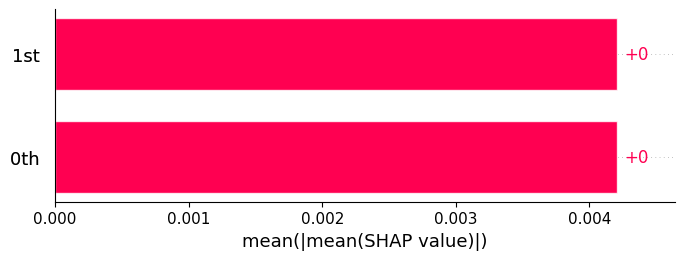


Beispieltext:
Lieber Jens_1978,  danke für Ihren Hinweis. Wir haben die Info an die Kollegen vom Portalmanagement weitergegeben. Sorry, dass unsere Seite bei Ihnen offenbar Probleme macht.  Herzliche Grüße,  Rainer Leurs Redaktionsleiter RP ONLINE ‎


In [ ]:
import shap
import numpy as np
import pandas as pd
device = "cuda" if torch.cuda.is_available() else "cpu"

def predict_proba(texts):
    # Stelle sicher, dass texts eine Liste von Strings ist
    if isinstance(texts, str):
        texts = [texts]
    # Filtere NaN-Werte und konvertiere zu Strings
    texts = [str(t) if pd.notna(t) else "" for t in texts]
    texts = [t for t in texts if t.strip()]  # Entferne leere Strings
    
    if not texts:
        return np.array([])
    
    enc = tokenizer(texts, padding=True, truncation=True, max_length=MAX_LEN, return_tensors="pt")
    enc = {k: v.to(device) for k, v in enc.items()}
    with torch.no_grad():
        out = model(**enc)
        logits = out.logits.detach().cpu().numpy()
        e = np.exp(logits - logits.max(axis=1, keepdims=True))
        p = e / e.sum(axis=1, keepdims=True)
        return p

masker = shap.maskers.Text(tokenizer)

# Bereite sample_texts vor: Entferne NaN-Werte, konvertiere zu Strings, entferne leere Strings
sample_texts_raw = validate_df["text"].dropna().astype(str).tolist()
sample_texts = [t for t in sample_texts_raw if t.strip()][:100]  # Nimm die ersten 100 gültigen Texte

print(f"Anzahl gültiger Texte für SHAP-Analyse: {len(sample_texts)}")

if len(sample_texts) == 0:
    print("⚠️  Keine gültigen Texte gefunden!")
else:
    explainer = shap.Explainer(predict_proba, masker)
    print("Starte SHAP-Analyse (dies kann einige Minuten dauern)...")
    sv = explainer(sample_texts)
    
    shap.plots.bar(sv.mean(0), max_display=20)
    
    idx = 0
    print("\nBeispieltext:")
    print(sample_texts[idx])
    shap.plots.text(sv[idx])

## 10. Bias-Screening

In [ ]:
# Bias-Screening: Analysiere Modell-Performance für verschiedene Gruppen
print("Bereite Bias-Screening vor...")

# Erstelle Vorhersagen auf Testdaten, falls noch nicht vorhanden
if 'y_true' not in globals() or 'y_pred' not in globals():
    print("Erstelle Vorhersagen auf Testdaten...")
    import torch
    
    # Stelle sicher, dass das Modell im Evaluationsmodus ist
    model.eval()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    
    # Bereite Testdaten vor
    test_texts = validate_df["text"].fillna("").tolist()
    y_true = validate_df["labels"].values
    
    # Erstelle Vorhersagen
    y_pred = []
    batch_size = 32
    
    with torch.no_grad():
        for i in range(0, len(test_texts), batch_size):
            batch_texts = test_texts[i:i+batch_size]
            encodings = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=MAX_LEN,
                return_tensors="pt"
            )
            encodings = {k: v.to(device) for k, v in encodings.items()}
            
            outputs = model(**encodings)
            predictions = torch.argmax(outputs.logits, dim=-1)
            y_pred.extend(predictions.cpu().numpy())
    
    y_pred = np.array(y_pred)
    print(f"✅ Vorhersagen erstellt: {len(y_pred)} Samples")
    print(f"   y_true Verteilung: {np.bincount(y_true)}")
    print(f"   y_pred Verteilung: {np.bincount(y_pred)}")
else:
    print("✅ y_true und y_pred bereits vorhanden")

# Definiere Gruppen für Bias-Analyse
groups = {
    "ethnisch_migration": ["flüchtling", "migrant", "ausländer", "muslim", "jude", "türke", "araber", "schwarze", "inder", "chinese"],
    "geschlecht_lgbtq": ["frau", "frauen", "mädchen", "mann", "männer", "lgbtq", "lesbe", "schwul", "trans", "drag"],
    "religion": ["christ", "buddhist", "buddhistin", "islam", "judentum"]
}
text_lower = validate_df["text"].str.lower()

def group_mask(kw_list):
    m = pd.Series(False, index=validate_df.index)
    for kw in kw_list:
        m |= text_lower.str.contains(rf"\b{kw}\b", regex=True)
    return m

rows = []
for g, kws in groups.items():
    m = group_mask(kws)
    if m.sum() == 0:
        continue
    yt, yp = y_true[m], y_pred[m]
    rep = classification_report(yt, yp, output_dict=True, zero_division=0)
    rows.append({
        "gruppe": g,
        "anzahl": int(m.sum()),
        "acc": rep["accuracy"],
        "precision_1": rep["1"]["precision"],
        "recall_1": rep["1"]["recall"],
        "f1_1": rep["1"]["f1-score"],
        "precision_0": rep["0"]["precision"],
        "recall_0": rep["0"]["recall"],
        "f1_0": rep["0"]["f1-score"],
    })

bias_df = pd.DataFrame(rows).sort_values("f1_1", ascending=False)
print("\n✅ Bias-Screening abgeschlossen:")
bias_df

Bereite Bias-Screening vor...
Erstelle Vorhersagen auf Testdaten...
✅ Vorhersagen erstellt: 9603 Samples
   y_true Verteilung: [8407 1196]
   y_pred Verteilung: [8533 1070]

✅ Bias-Screening abgeschlossen:


,gruppe,anzahl,acc,precision_1,recall_1,f1_1,precision_0,recall_0,f1_0
0,ethnisch_migration,223,0.771300,0.780000,0.728972,0.753623,0.764228,0.810345,0.786611
1,geschlecht_lgbtq,901,0.897891,0.726257,0.751445,0.738636,0.940443,0.932692,0.936552
2,religion,79,0.772152,0.578947,0.523810,0.550000,0.833333,0.862069,0.847458


## 11. Active-Learning-Export

In [ ]:
# Active Learning: Exportiere unsichere Vorhersagen und Fehler für manuelle Annotation
print("Bereite Active Learning Export vor...")

# Erstelle y_prob (Wahrscheinlichkeiten) falls noch nicht vorhanden
if 'y_prob' not in globals() or 'y_pred' not in globals():
    print("Erstelle Vorhersagen mit Wahrscheinlichkeiten auf Testdaten...")
    import torch
    
    # Stelle sicher, dass das Modell im Evaluationsmodus ist
    model.eval()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    
    # Bereite Testdaten vor
    test_texts = validate_df["text"].fillna("").tolist()
    
    # Erstelle Vorhersagen mit Wahrscheinlichkeiten
    y_prob_list = []
    y_pred_list = []
    batch_size = 32
    
    with torch.no_grad():
        for i in range(0, len(test_texts), batch_size):
            batch_texts = test_texts[i:i+batch_size]
            encodings = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=MAX_LEN,
                return_tensors="pt"
            )
            encodings = {k: v.to(device) for k, v in encodings.items()}
            
            outputs = model(**encodings)
            logits = outputs.logits
            
            # Softmax für Wahrscheinlichkeiten
            probs = torch.softmax(logits, dim=-1)
            predictions = torch.argmax(logits, dim=-1)
            
            y_prob_list.append(probs.cpu().numpy())
            y_pred_list.extend(predictions.cpu().numpy())
    
    y_prob = np.vstack(y_prob_list)
    y_pred = np.array(y_pred_list)
    print(f"✅ Vorhersagen mit Wahrscheinlichkeiten erstellt: {len(y_pred)} Samples")
else:
    print("✅ y_prob und y_pred bereits vorhanden")

# Normalisiere Wahrscheinlichkeiten (sollte bereits normalisiert sein, aber zur Sicherheit)
probs = y_prob / y_prob.sum(axis=1, keepdims=True)
margin = np.abs(probs[:,1] - probs[:,0])
test_df_al = validate_df.copy()
test_df_al["pred"] = y_pred
test_df_al["p_hate"] = probs[:,1]
test_df_al["uncertainty"] = 1 - margin

N = 300
al_uncertain = test_df_al.sort_values("uncertainty", ascending=False).head(N)
al_errors = test_df_al[test_df_al["pred"] != test_df_al["labels"]]

al_path1 = OUT_DIR / f"active_learning_uncertain_{RUN_NAME}.csv"
al_path2 = OUT_DIR / f"active_learning_errors_{RUN_NAME}.csv"
al_uncertain.to_csv(al_path1, index=False, encoding="utf-8-sig")
al_errors.to_csv(al_path2, index=False, encoding="utf-8-sig")
print(f"\n✅ Active Learning Export abgeschlossen:")
print(f"   Unsichere Vorhersagen ({N} Samples): {al_path1}")
print(f"   Fehlerhafte Vorhersagen ({len(al_errors)} Samples): {al_path2}")

Bereite Active Learning Export vor...
Erstelle Vorhersagen mit Wahrscheinlichkeiten auf Testdaten...
✅ Vorhersagen mit Wahrscheinlichkeiten erstellt: 9603 Samples

✅ Active Learning Export abgeschlossen:
   Unsichere Vorhersagen (300 Samples): results_gbert-base_gahd_hatespeech_2025-11-04\active_learning_uncertain_gbert-base_gahd_hatespeech_2025-11-04.csv
   Fehlerhafte Vorhersagen (742 Samples): results_gbert-base_gahd_hatespeech_2025-11-04\active_learning_errors_gbert-base_gahd_hatespeech_2025-11-04.csv


## 12. Inferenz-Funktion

In [51]:
def predict_texts(texts):
    enc = tokenizer(texts, padding=True, truncation=True, max_length=MAX_LEN, return_tensors="pt")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    enc = {k: v.to(device) for k, v in enc.items()}
    with torch.no_grad():
        out = model(**enc)
        logits = out.logits.detach().cpu().numpy()
        e = np.exp(logits - logits.max(axis=1, keepdims=True))
        p = e / e.sum(axis=1, keepdims=True)
    preds = p.argmax(axis=1).tolist()
    return [{"text": t, "p_non_hate": float(p[i,0]), "p_hate": float(p[i,1]), "pred": int(preds[i])} for i, t in enumerate(texts)]

predict_texts([
    "Ich liebe unsere Nachbarn, sie sind toll.",
    "Drags sind Fehler der Natur.",
    "Es sind beides unsere Hunde, aber den schwarzen mag ich nicht so."
])

[{'text': 'Ich liebe unsere Nachbarn, sie sind toll.',
  'p_non_hate': 0.9998306035995483,
  'p_hate': 0.0001693886297289282,
  'pred': 0},
 {'text': 'Drags sind Fehler der Natur.',
  'p_non_hate': 0.0003613598528318107,
  'p_hate': 0.9996386766433716,
  'pred': 1},
 {'text': 'Es sind beides unsere Hunde, aber den schwarzen mag ich nicht so.',
  'p_non_hate': 0.9989200830459595,
  'p_hate': 0.0010799308074638247,
  'pred': 0}]

## 13. Modellkarte

In [52]:
card = {
    "base_model": BASE_MODEL_NAME,
    "dataset": "GAHD (clean_hatespeech_dataset.csv)",
    "date": TODAY,
    "notes": [
        "Transformer-basiertes DE/CH Hate-Speech-Modell.",
        "GPU-Unterstützung, Early Stopping, Mixed Precision (CUDA).",
        "Explainability mit SHAP (Text-Masker).",
        "Bias-Screening und Active-Learning-Exports."
    ]
}
with open(OUT_DIR / f"model_card_{'{'}RUN_NAME{'}'}.json", "w", encoding="utf-8") as f:
    json.dump(card, f, ensure_ascii=False, indent=2)
print("Gespeichert:", OUT_DIR / f"model_card_{'{'}RUN_NAME{'}'}.json")

Gespeichert: results_gbert-base_gahd_hatespeech_2025-11-04\model_card_{RUN_NAME}.json
